## Data Preparation and EDA

### Download dataset and import libraries

In [2]:
# !pip install opendatasets

# import opendatasets as od
# username = normanlapid
# API_key = c153837540a86c2d226f5d2967a55f55
# od.download("https://www.kaggle.com/rdizzl3/jpeg-happywhale-384x384")

In [181]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

from tqdm import tqdm
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import random

import warnings
warnings.filterwarnings('ignore')

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(2)
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [5]:
print("TensorFlow:", tf.__version__)

TensorFlow: 2.6.0


In [6]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)


seed_everything(143) 

### Data cleaning and EDA

In [7]:
df_train = pd.read_csv('jpeg-happywhale-384x384/train.csv')

In [8]:
df_train['species'].value_counts().sort_index()

beluga                       7443
blue_whale                   4830
bottlenose_dolphin           9664
bottlenose_dolpin            1117
brydes_whale                  154
commersons_dolphin             90
common_dolphin                347
cuviers_beaked_whale          341
dusky_dolphin                3139
false_killer_whale           3326
fin_whale                    1324
frasiers_dolphin               14
globis                        116
gray_whale                   1123
humpback_whale               7392
kiler_whale                   962
killer_whale                 1493
long_finned_pilot_whale       238
melon_headed_whale           1689
minke_whale                  1608
pantropic_spotted_dolphin     145
pilot_whale                   262
pygmy_killer_whale             76
rough_toothed_dolphin          60
sei_whale                     428
short_finned_pilot_whale      367
southern_right_whale          866
spinner_dolphin              1700
spotted_dolphin               490
white_sided_do

In [9]:
df_train['species'].replace({"globis": "short_finned_pilot_whale",
                             "pilot_whale": "short_finned_pilot_whale",
                             "kiler_whale": "killer_whale",
                             "bottlenose_dolpin": "bottlenose_dolphin"},
                            inplace=True)

In [10]:
df_train.head()

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392


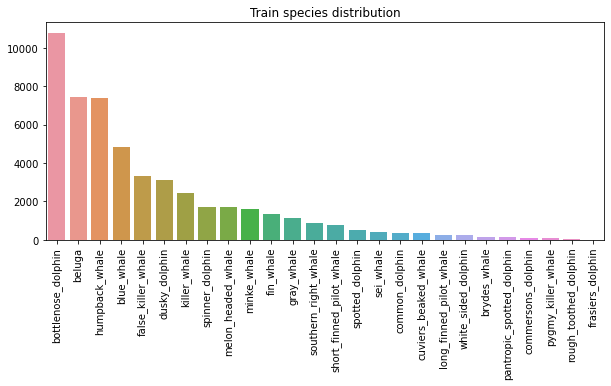

In [11]:
train_val_count = df_train['species'].value_counts()

fig, ax = plt.subplots(figsize=(10, 4))

chart = sns.barplot(x=train_val_count.index, y=train_val_count.values, ax=ax)
ax.set_title('Train species distribution')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

### Parameters

In [12]:
work_dir = "./jpeg-happywhale-384x384"
train_folder = "train_images"
test_folder = "test_images"
img_col = "image"
label_col = "individual_id"
specie_col = "species"

target_col = specie_col
num_classes = len(df_train[target_col].value_counts())

In [13]:
# print(os.listdir(WORK_DIR))
print('Train images: %d' %len(os.listdir(
    os.path.join(work_dir, train_folder))))
print('Test images: %d' %len(os.listdir(
    os.path.join(work_dir, test_folder))))

Train images: 51033
Test images: 27956


In [14]:
specie_names = df_train['species'].value_counts().index
specie_idx_map = {specie: idx for idx, specie in enumerate(specie_names)}
idx_specie_map = {idx: specie for specie, idx in specie_idx_map.items()}

In [15]:
label_names = df_train['individual_id'].value_counts().index
label_idx_map = {label: idx for idx, label in enumerate(label_names)}
idx_label_map = {idx: label for label, idx in label_idx_map.items()}

In [16]:
df_train["species_idx"] = df_train['species'].map(specie_idx_map)
df_train["individual_idx"] = df_train['individual_id'].map(label_idx_map)

In [17]:
df_train.head()

,image,species,individual_id,species_idx,individual_idx
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9,8,6441
1,000562241d384d.jpg,humpback_whale,1a71fbb72250,2,4879
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b,4,70
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063,0,69
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392,2,112


In [192]:
batch_size = 32
steps_per_epoch = len(df_train) * 0.8 / batch_size
validation_steps = len(df_train) * 0.2 / batch_size
epochs = 4
target_size = 256

### Data augmentation and prepare data generators

In [19]:
# Training set
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2,
                                   preprocessing_function=None,
                                   rotation_range=45,
                                   zoom_range=0.2,
                                   brightness_range=[0.6, 1.4],
                                   channel_shift_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   shear_range=0.1,
                                   height_shift_range=0.1,
                                   width_shift_range=0.1)

train_generator = (
    train_datagen.
    flow_from_dataframe(df_train,
                        directory = os.path.join(work_dir, train_folder),
                        subset="training",
                        x_col=img_col,
                        y_col=target_col,
                        color_mode='rgb',
                        target_size=(target_size, target_size),
                        batch_size=batch_size,
                        class_mode="categorical")
)

# Validation set
val_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.2)

val_generator = (
    val_datagen.
    flow_from_dataframe(df_train,
                        directory=os.path.join(work_dir, train_folder),
                        subset="validation",
                        color_mode='rgb',
                        x_col=img_col,
                        y_col=target_col,
                        target_size=(target_size, target_size),
                        batch_size=batch_size,
                        class_mode="categorical")
)

Found 40827 validated image filenames belonging to 26 classes.
Found 10206 validated image filenames belonging to 26 classes.


## Model Architecture Comparison

### Baseline CNN Model

In [137]:
tf.keras.backend.clear_session()

In [138]:
model = models.Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=6, strides=1, padding='same',
                 input_shape=(target_size, target_size, 3)))
model.add(layers.BatchNormalization(axis=3))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=3, strides=1,  padding='same',
                        activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3, 3)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      3488      
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 112896)            0

In [139]:
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [140]:
%%time

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps
)


Epoch 1/4
1275/1275 [==============================] - 1921s 2s/step - loss: 2.6327 - accuracy: 0.3315 - val_loss: 2.3206 - val_accuracy: 0.3727
Epoch 2/4
1275/1275 [==============================] - 766s 601ms/step - loss: 2.0935 - accuracy: 0.3948 - val_loss: 1.8187 - val_accuracy: 0.4699
Epoch 3/4
1275/1275 [==============================] - 762s 597ms/step - loss: 1.9844 - accuracy: 0.4185 - val_loss: 1.8154 - val_accuracy: 0.4430
Epoch 4/4
1275/1275 [==============================] - 765s 599ms/step - loss: 1.8964 - accuracy: 0.4391 - val_loss: 1.6203 - val_accuracy: 0.5039
CPU times: user 57min 33s, sys: 52.7 s, total: 58min 26s
Wall time: 1h 10min 14s


In [142]:
model.save(work_dir + '/baseline_cnn.h5')

import pickle
with open(work_dir + '/baseline_cnn_hist.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
def plot_results(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

    # plot accuracy 
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    ax1.plot(epochs, acc, 'ko', label='Training acc')
    ax1.plot(epochs, val_acc, 'k', label='Validation acc')
    ax1.set_title('Training and validation accuracy')
    ax1.set_xlabel('Epochs')
    ax1.legend()

    # plot loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    ax2.plot(epochs, loss, 'ro', label='Training loss')
    ax2.plot(epochs, val_loss, 'r', label='Validation loss')
    ax2.set_title('Training and validation loss')
    ax2.set_xlabel('Epochs')
    ax2.legend()

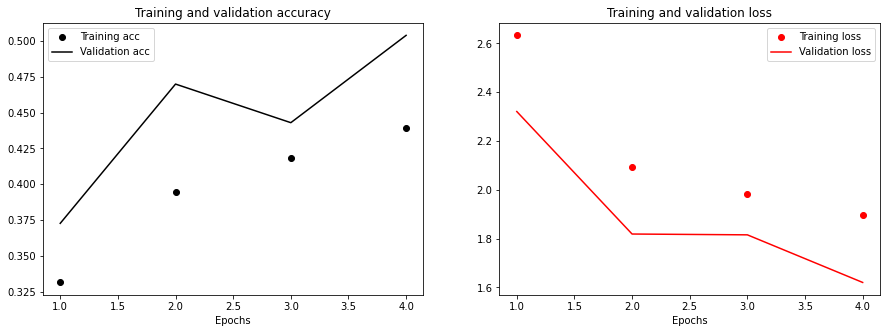

In [146]:
plot_results(history)

### Transfer Learning with Inception V3

In [229]:
tf.keras.backend.clear_session()

#### Train only top layer

In [230]:
inception_v3 = tf.keras.applications.InceptionV3(
    input_shape=(target_size, target_size, 3),
    include_top=False,
    weights = "imagenet")

inception_v3.trainable = False

model_inv3 = models.Sequential()

model_inv3.add(inception_v3)
model_inv3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_inv3.add(layers.Flatten())
model_inv3.add(layers.Dense(256, activation="relu"))
model_inv3.add(layers.Dropout(0.5))
model_inv3.add(layers.Dense(num_classes, activation='softmax'))

model_inv3.summary()

model_inv3.compile(loss='categorical_crossentropy',
                   optimizer="adam",
                   metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               4718848   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                6682      
Total params: 26,528,314
Trainable params: 4,725,530
Non-trainable params: 21,802,784
____________________________________

In [231]:
%%time

history_inv3 = model_inv3.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/4
1275/1275 [==============================] - 3405s 3s/step - loss: 2.4507 - accuracy: 0.3299 - val_loss: 1.6597 - val_accuracy: 0.5834
Epoch 2/4
1275/1275 [==============================] - 956s 750ms/step - loss: 2.0679 - accuracy: 0.3652 - val_loss: 1.5370 - val_accuracy: 0.5440
Epoch 3/4
1275/1275 [==============================] - 955s 748ms/step - loss: 1.9729 - accuracy: 0.4002 - val_loss: 1.5126 - val_accuracy: 0.5510
Epoch 4/4
1275/1275 [==============================] - 940s 737ms/step - loss: 1.9493 - accuracy: 0.4092 - val_loss: 1.4943 - val_accuracy: 0.5603
CPU times: user 1h 15min 29s, sys: 1min 11s, total: 1h 16min 40s
Wall time: 1h 44min 22s


#### Unfreeze part of base model and retrain

In [232]:
inception_v3.trainable = True

for layer in inception_v3.layers[:249]:
    layer.trainable = False
for layer in inception_v3.layers[249:]:
    layer.trainable = True

model_inv3.compile(loss='categorical_crossentropy',
                   optimizer="adam",
                   metrics=['accuracy'])

model_inv3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               4718848   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                6682      
Total params: 26,528,314
Trainable params: 15,840,410
Non-trainable params: 10,687,904
___________________________________

In [233]:
%%time

history_inv3 = model_inv3.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/4
1275/1275 [==============================] - 937s 731ms/step - loss: 1.8199 - accuracy: 0.4698 - val_loss: 1.3411 - val_accuracy: 0.5914
Epoch 2/4
1275/1275 [==============================] - 928s 727ms/step - loss: 1.5445 - accuracy: 0.5334 - val_loss: 1.1771 - val_accuracy: 0.6120
Epoch 3/4
1275/1275 [==============================] - 934s 732ms/step - loss: 1.3385 - accuracy: 0.5895 - val_loss: 0.9947 - val_accuracy: 0.7124
Epoch 4/4
1275/1275 [==============================] - 923s 723ms/step - loss: 1.1306 - accuracy: 0.6644 - val_loss: 0.8278 - val_accuracy: 0.7659
CPU times: user 1h 5min 34s, sys: 58.9 s, total: 1h 6min 33s
Wall time: 1h 2min 2s


In [234]:
model_inv3.save(work_dir + '/inception_v3.h5')

with open(work_dir + '/inception_v3_hist.pickle', 'wb') as handle:
    pickle.dump(history_inv3.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

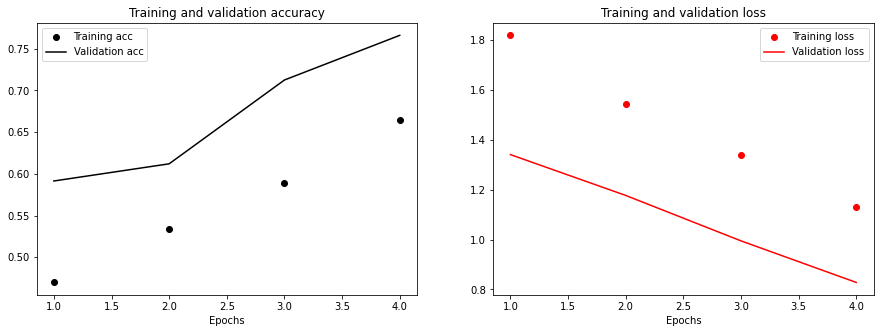

In [235]:
plot_results(history_inv3)

### Transfer Learning with VGG16 + Fine-Tuning

In [108]:
tf.keras.backend.clear_session()

#### Train only top layer

In [109]:
vgg16 = tf.keras.applications.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(target_size, target_size, 3))

vgg16.trainable = False

model_vgg16 = models.Sequential()

model_vgg16.add(vgg16)
model_vgg16.add(layers.Flatten())
model_vgg16.add(layers.Dense(256, activation="relu"))
model_vgg16.add(layers.Dropout(0.5))
model_vgg16.add(layers.Dense(num_classes, activation='softmax'))

model_vgg16.summary()

model_vgg16.compile(loss='categorical_crossentropy',
                   optimizer="adam",
                   metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                6682      
Total params: 23,110,234
Trainable params: 8,395,546
Non-trainable params: 14,714,688
_________________________________________________________________


In [110]:
%%time

history_vgg16 = model_vgg16.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/4
1275/1275 [==============================] - 1057s 828ms/step - loss: 2.0172 - accuracy: 0.4044 - val_loss: 1.3413 - val_accuracy: 0.5918
Epoch 2/4
1275/1275 [==============================] - 1118s 876ms/step - loss: 1.7539 - accuracy: 0.4655 - val_loss: 1.2772 - val_accuracy: 0.5977
Epoch 3/4
1275/1275 [==============================] - 1113s 873ms/step - loss: 1.7003 - accuracy: 0.4728 - val_loss: 1.2412 - val_accuracy: 0.6112
Epoch 4/4
1275/1275 [==============================] - 1076s 843ms/step - loss: 1.6745 - accuracy: 0.4807 - val_loss: 1.2509 - val_accuracy: 0.5978
CPU times: user 1h 10min 17s, sys: 2min 58s, total: 1h 13min 16s
Wall time: 1h 12min 45s


#### Unfreeze part of base model and retrain

In [111]:
vgg16.trainable = True

for layer in vgg16.layers[:15]:
    layer.trainable = False
for layer in vgg16.layers[15:]:
    layer.trainable = True
    
model_vgg16.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.Adam(learning_rate=1e-5),
                   metrics=['accuracy'])

vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [112]:
%%time

history_vgg16 = model_vgg16.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/4
1275/1275 [==============================] - 1044s 818ms/step - loss: 1.5381 - accuracy: 0.5197 - val_loss: 1.0567 - val_accuracy: 0.6627
Epoch 2/4
1275/1275 [==============================] - 1064s 834ms/step - loss: 1.4236 - accuracy: 0.5568 - val_loss: 1.0146 - val_accuracy: 0.6731
Epoch 3/4
1275/1275 [==============================] - 1059s 830ms/step - loss: 1.3607 - accuracy: 0.5792 - val_loss: 0.9543 - val_accuracy: 0.6924
Epoch 4/4
1275/1275 [==============================] - 1054s 826ms/step - loss: 1.3085 - accuracy: 0.5962 - val_loss: 0.9079 - val_accuracy: 0.7119
CPU times: user 1h 9min 29s, sys: 2min 33s, total: 1h 12min 3s
Wall time: 1h 10min 22s


In [113]:
model_vgg16.save(work_dir + '/vgg16.h5')

with open(work_dir + '/vgg16_hist.pickle', 'wb') as handle:
    pickle.dump(history_vgg16.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

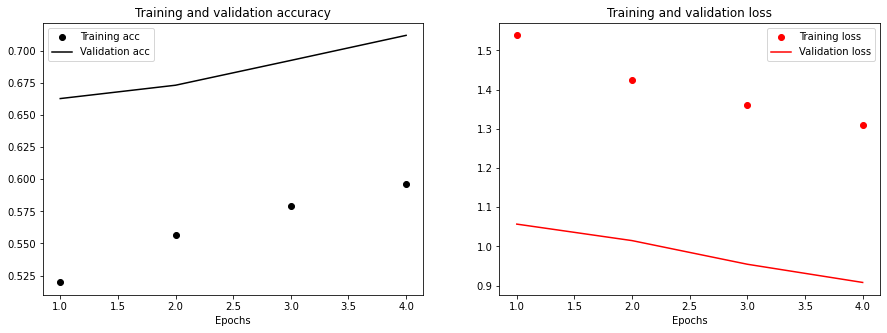

In [114]:
plot_results(history_vgg16)

### Transfer Learning with EfficientNet

In [34]:
tf.keras.backend.clear_session()

#### Train only top layer

In [35]:
effnetb0 = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(target_size, target_size, 3))

effnetb0.trainable = False

model_effb0 = models.Sequential()

model_effb0.add(effnetb0)
model_effb0.add(layers.GlobalAveragePooling2D(name="avg_pool"))
model_effb0.add(layers.BatchNormalization())
model_effb0.add(layers.Dense(256, activation="relu"))
model_effb0.add(layers.Dropout(0.5))
model_effb0.add(layers.Dense(num_classes, activation='softmax'))

model_effb0.summary()

model_effb0.compile(loss='categorical_crossentropy',
                   optimizer="adam",
                   metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 8, 8, 1280)        4049571   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                6682      
Total params: 4,389,309
Trainable params: 337,178
Non-trainable params: 4,052,131
________________________________________

In [36]:
%%time


history_effb0 = model_effb0.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/4
1275/1275 [==============================] - 858s 668ms/step - loss: 2.7274 - accuracy: 0.1833 - val_loss: 2.5645 - val_accuracy: 0.2124
Epoch 2/4
1275/1275 [==============================] - 857s 672ms/step - loss: 2.5744 - accuracy: 0.2078 - val_loss: 2.5304 - val_accuracy: 0.2116
Epoch 3/4
1275/1275 [==============================] - 854s 669ms/step - loss: 2.5583 - accuracy: 0.2086 - val_loss: 2.5276 - val_accuracy: 0.2116
Epoch 4/4
1275/1275 [==============================] - 852s 668ms/step - loss: 2.5503 - accuracy: 0.2093 - val_loss: 2.5245 - val_accuracy: 0.2116
CPU times: user 57min 55s, sys: 58.1 s, total: 58min 53s
Wall time: 57min 1s


#### Unfreeze part of base model and retrain

In [37]:
effnetb0.trainable = True

for layer in effnetb0.layers[:-20]:
    layer.trainable = False
for layer in effnetb0.layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True
        
model_effb0.compile(loss='categorical_crossentropy',
                    optimizer="adam",
                    metrics=['accuracy'])

model_effb0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 8, 8, 1280)        4049571   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                6682      
Total params: 4,389,309
Trainable params: 1,688,138
Non-trainable params: 2,701,171
______________________________________

In [38]:
%%time


history_effb0 = model_effb0.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/4
1275/1275 [==============================] - 851s 663ms/step - loss: 2.5639 - accuracy: 0.2076 - val_loss: 2.5249 - val_accuracy: 0.2116
Epoch 2/4
1275/1275 [==============================] - 868s 680ms/step - loss: 2.5430 - accuracy: 0.2099 - val_loss: 2.5263 - val_accuracy: 0.2116
Epoch 3/4
1275/1275 [==============================] - 892s 699ms/step - loss: 2.5378 - accuracy: 0.2107 - val_loss: 2.5241 - val_accuracy: 0.2116
Epoch 4/4
1275/1275 [==============================] - 886s 694ms/step - loss: 2.5340 - accuracy: 0.2108 - val_loss: 2.5229 - val_accuracy: 0.2116
CPU times: user 1h 2s, sys: 1min 20s, total: 1h 1min 22s
Wall time: 58min 18s


In [39]:
model_effb0.save(work_dir + '/effb0.h5')

with open(work_dir + '/effb0_hist.pickle', 'wb') as handle:
    pickle.dump(history_effb0.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

/home/msds2022/nlapid/.conda/envs/msds2022-ml3/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


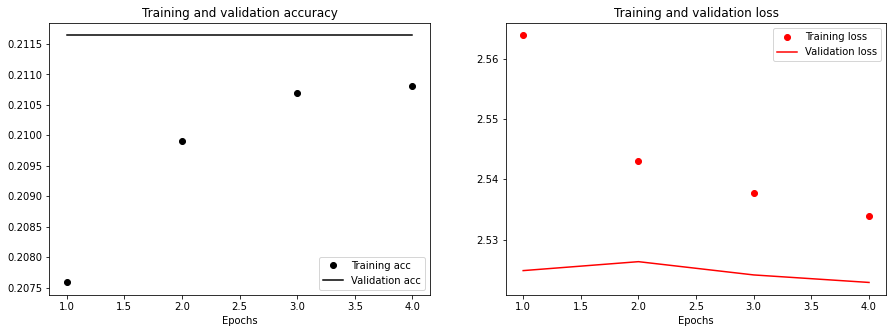

In [40]:
plot_results(history_effb0)

### CoAtNet + Fine-Tuning

In [46]:
# !pip install -U keras-cv-attention-models
import keras_cv_attention_models

#### Adjust model inputs to match CoAtNet weights

In [79]:
coat_target_size = 224

coat_train_gen = (
    train_datagen.
    flow_from_dataframe(df_train,
                        directory = os.path.join(work_dir, train_folder),
                        subset="training",
                        x_col=img_col,
                        y_col=target_col,
                        color_mode='rgb',
                        target_size=(coat_target_size, coat_target_size),
                        batch_size=batch_size,
                        class_mode="categorical")
)

coat_val_gen = (
    val_datagen.
    flow_from_dataframe(df_train,
                        directory=os.path.join(work_dir, train_folder),
                        subset="validation",
                        color_mode='rgb',
                        x_col=img_col,
                        y_col=target_col,
                        target_size=(coat_target_size, coat_target_size),
                        batch_size=batch_size,
                        class_mode="categorical")
)

Found 40827 validated image filenames belonging to 26 classes.
Found 10206 validated image filenames belonging to 26 classes.


#### Train top layer

In [80]:
tf.keras.backend.clear_session()

In [81]:
coatnet0 = keras_cv_attention_models.coatnet.CoAtNet0(
    num_classes=0,    # to exclude top layers
    input_shape=(coat_target_size, coat_target_size, 3))

coatnet0.trainable = False

model_coat0 = models.Sequential()

model_coat0.add(coatnet0)
model_coat0.add(layers.Flatten())
model_coat0.add(layers.Dense(256, activation="relu"))
model_coat0.add(layers.Dropout(0.5))
model_coat0.add(layers.Dense(num_classes, activation='softmax'))

model_coat0.summary()

model_coat0.compile(loss='categorical_crossentropy',
                   optimizer="adam",
                   metrics=['accuracy'])

>>>> Load pretrained from: /home/msds2022/nlapid/.keras/models/coatnet0_224_imagenet.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
coatnet0 (Functional)        (None, 7, 7, 768)         23075178  
_________________________________________________________________
flatten (Flatten)            (None, 37632)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               9634048   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                6682      
Total params: 32,715,908
Trainable params: 9,640,730
Non-trainable params: 23,075,178
_________________________________________________________________


In [82]:
%%time


history_coat0 = model_coat0.fit(
    coat_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=coat_val_gen,
    validation_steps=validation_steps
)

Epoch 1/4
1275/1275 [==============================] - 766s 594ms/step - loss: 1.9548 - accuracy: 0.4941 - val_loss: 1.1778 - val_accuracy: 0.6244
Epoch 2/4
1275/1275 [==============================] - 799s 626ms/step - loss: 1.5249 - accuracy: 0.5502 - val_loss: 0.9901 - val_accuracy: 0.6783
Epoch 3/4
1275/1275 [==============================] - 792s 620ms/step - loss: 1.4185 - accuracy: 0.5711 - val_loss: 0.9658 - val_accuracy: 0.6963
Epoch 4/4
1275/1275 [==============================] - 848s 664ms/step - loss: 1.3750 - accuracy: 0.5893 - val_loss: 0.9660 - val_accuracy: 0.7038
CPU times: user 56min 34s, sys: 1min 33s, total: 58min 8s
Wall time: 53min 24s


In [106]:
model_coat0.save(work_dir + '/coat0.h5')

with open(work_dir + '/coat0_hist.pickle', 'wb') as handle:
    pickle.dump(history_coat0.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

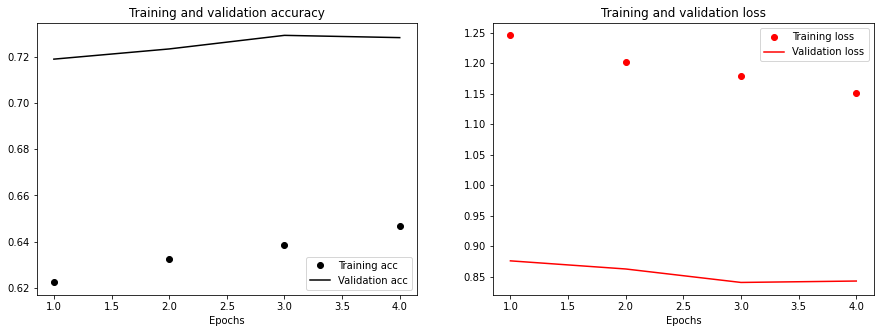

In [107]:
plot_results(history_coat0)

#### Unfreeze part of base model and retrain

In [104]:
coatnet0.trainable = True

for layer in coatnet0.layers[:-7]:
    layer.trainable = False
for layer in coatnet0.layers[-7:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True
        
model_coat0.compile(loss='categorical_crossentropy',
                    optimizer=optimizers.Adam(learning_rate=1e-5),
                    metrics=['accuracy'])

model_coat0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
coatnet0 (Functional)        (None, 7, 7, 768)         23075178  
_________________________________________________________________
flatten (Flatten)            (None, 37632)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               9634048   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                6682      
Total params: 32,715,908
Trainable params: 14,950,682
Non-trainable params: 17,765,226
_________________________________________________________________


In [101]:
%%time


history_coat0 = model_coat0.fit(
    coat_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=coat_val_gen,
    validation_steps=validation_steps
)

Epoch 1/4
1275/1275 [==============================] - 808s 628ms/step - loss: 1.2456 - accuracy: 0.6223 - val_loss: 0.8758 - val_accuracy: 0.7189
Epoch 2/4
1275/1275 [==============================] - 800s 627ms/step - loss: 1.2021 - accuracy: 0.6326 - val_loss: 0.8625 - val_accuracy: 0.7233
Epoch 3/4
1275/1275 [==============================] - 799s 626ms/step - loss: 1.1795 - accuracy: 0.6386 - val_loss: 0.8404 - val_accuracy: 0.7292
Epoch 4/4
1275/1275 [==============================] - 807s 632ms/step - loss: 1.1513 - accuracy: 0.6467 - val_loss: 0.8427 - val_accuracy: 0.7282
CPU times: user 57min 29s, sys: 1min 26s, total: 58min 56s
Wall time: 53min 34s


In [102]:
model_coat0.save(work_dir + '/coat0_ft.h5')

with open(work_dir + '/coat0_hist_ft.pickle', 'wb') as handle:
    pickle.dump(history_coat0.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

/home/msds2022/nlapid/.conda/envs/msds2022-ml3/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


### LeViT

In [193]:
tf.keras.backend.clear_session()

In [194]:
levit_target_size = 224
levit_train_gen = coat_train_gen
levit_val_gen = coat_val_gen

#### Train top layer

In [195]:
levit192 = keras_cv_attention_models.levit.LeViT128(
    num_classes=0,
    input_shape=(levit_target_size, levit_target_size, 3))

levit192.trainable = False

model_levit = models.Sequential()

model_levit.add(levit192)
model_levit.add(layers.Flatten())
model_levit.add(layers.Dense(256, activation="relu"))
model_levit.add(layers.Dropout(0.5))
model_levit.add(layers.Dense(num_classes, activation='softmax'))

model_levit.summary()

model_levit.compile(loss='categorical_crossentropy',
                   optimizer="adam",
                   metrics=['accuracy'])

>>>> Load pretrained from: /home/msds2022/nlapid/.keras/models/levit128_imagenet.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
levit128 (Functional)        (None, 16, 384)           8489472   
_________________________________________________________________
flatten (Flatten)            (None, 6144)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1573120   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                6682      
Total params: 10,069,274
Trainable params: 1,579,802
Non-trainable params: 8,489,472
_________________________________________________________________


In [196]:
%%time


history_levit = model_levit.fit(
    levit_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=levit_val_gen,
    validation_steps=validation_steps
)

Epoch 1/4
1275/1275 [==============================] - 792s 613ms/step - loss: 1.9241 - accuracy: 0.5336 - val_loss: 1.1031 - val_accuracy: 0.6681
Epoch 2/4
1275/1275 [==============================] - 769s 603ms/step - loss: 1.4098 - accuracy: 0.6063 - val_loss: 0.9783 - val_accuracy: 0.7054
Epoch 3/4
1275/1275 [==============================] - 923s 724ms/step - loss: 1.3294 - accuracy: 0.6247 - val_loss: 0.9055 - val_accuracy: 0.7185
Epoch 4/4
1275/1275 [==============================] - 768s 602ms/step - loss: 1.2846 - accuracy: 0.6381 - val_loss: 0.8670 - val_accuracy: 0.7436
CPU times: user 57min 17s, sys: 1min 30s, total: 58min 48s
Wall time: 54min 13s


#### Unfreeze part of base model and retrain

In [198]:
levit192.trainable = True

for layer in levit192.layers[:-8]:
    layer.trainable = False
for layer in levit192.layers[-8:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True
        
model_levit.compile(loss='categorical_crossentropy',
                    optimizer=optimizers.Adam(learning_rate=1e-3),
                    metrics=['accuracy'])

model_levit.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
levit128 (Functional)        (None, 16, 384)           8489472   
_________________________________________________________________
flatten (Flatten)            (None, 6144)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1573120   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                6682      
Total params: 10,069,274
Trainable params: 2,171,930
Non-trainable params: 7,897,344
_________________________________________________________________


In [199]:
%%time


history_levit = model_levit.fit(
    levit_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=levit_val_gen,
    validation_steps=validation_steps
)

Epoch 1/4
1275/1275 [==============================] - 783s 605ms/step - loss: 1.3369 - accuracy: 0.6352 - val_loss: 1.0246 - val_accuracy: 0.7306
Epoch 2/4
1275/1275 [==============================] - 837s 656ms/step - loss: 1.2532 - accuracy: 0.6494 - val_loss: 1.0429 - val_accuracy: 0.7057
Epoch 3/4
1275/1275 [==============================] - 761s 596ms/step - loss: 1.2172 - accuracy: 0.6634 - val_loss: 1.1788 - val_accuracy: 0.7089
Epoch 4/4
1275/1275 [==============================] - 770s 604ms/step - loss: 1.1885 - accuracy: 0.6730 - val_loss: 0.9109 - val_accuracy: 0.7543
CPU times: user 58min 11s, sys: 1min 37s, total: 59min 48s
Wall time: 52min 31s


In [200]:
model_levit.save(work_dir + '/levit.h5')

with open(work_dir + '/levit_hist.pickle', 'wb') as handle:
    pickle.dump(history_levit.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Tuning the CoAtNet Model

In [172]:
batch_size = 64
steps_per_epoch = len(df_train) * 0.8 / batch_size
validation_steps = len(df_train) * 0.2 / batch_size
epochs = 10

target_col = specie_col
# target_col = label_col
num_classes = len(df_train[target_col].value_counts())

coat_target_size = 224

In [173]:
coat_train_gen = (
    train_datagen.
    flow_from_dataframe(df_train,
                        directory = os.path.join(work_dir, train_folder),
                        subset="training",
                        x_col=img_col,
                        y_col=target_col,
                        color_mode='rgb',
                        target_size=(coat_target_size, coat_target_size),
                        batch_size=batch_size,
                        class_mode="categorical")
)

coat_val_gen = (
    val_datagen.
    flow_from_dataframe(df_train,
                        directory=os.path.join(work_dir, train_folder),
                        subset="validation",
                        color_mode='rgb',
                        x_col=img_col,
                        y_col=target_col,
                        target_size=(coat_target_size, coat_target_size),
                        batch_size=batch_size,
                        class_mode="categorical")
)

Found 40827 validated image filenames belonging to 26 classes.
Found 10206 validated image filenames belonging to 26 classes.


In [174]:
tf.keras.backend.clear_session()

In [175]:
coatnet0_base = keras_cv_attention_models.coatnet.CoAtNet0(
    num_classes=0,    # to exclude top layers
    input_shape=(coat_target_size, coat_target_size, 3))

coatnet0_base.trainable = False

model_coat0_main = models.Sequential()

model_coat0_main.add(coatnet0_base)
model_coat0_main.add(layers.Flatten())
model_coat0_main.add(layers.Dense(256, activation="relu"))
model_coat0_main.add(layers.Dropout(0.5))
model_coat0_main.add(layers.Dense(num_classes, activation='softmax'))

model_coat0_main.summary()

>>>> Load pretrained from: /home/msds2022/nlapid/.keras/models/coatnet0_224_imagenet.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
coatnet0 (Functional)        (None, 7, 7, 768)         23075178  
_________________________________________________________________
flatten (Flatten)            (None, 37632)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               9634048   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                6682      
Total params: 32,715,908
Trainable params: 9,640,730
Non-trainable params: 23,075,178
_________________________________________________________________


In [176]:
metrics = [tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
           tf.keras.metrics.TopKCategoricalAccuracy(5, name="top_5_acc"),
           tf.keras.metrics.Precision(top_k=5, name="top_5_map")]

model_coat0_main.compile(loss='categorical_crossentropy',
                         optimizer=optimizers.Adam(),
                         metrics=metrics)

In [177]:
%%time

filepath = work_dir + "/coat_main_wts.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.00001, verbose=1)

history_coat0_main = model_coat0_main.fit(
    coat_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=coat_val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint, earlystop, reduce_lr]
)

Epoch 1/10
1275/1275 [==============================] - 1583s 1s/step - loss: 1.9231 - accuracy: 0.5008 - top_5_acc: 0.8082 - top_5_map: 0.1616 - val_loss: 1.1467 - val_accuracy: 0.6257 - val_top_5_acc: 0.9189 - val_top_5_map: 0.1838

Epoch 00001: val_accuracy improved from -inf to 0.62571, saving model to ./jpeg-happywhale-384x384/coat_main_wts.hdf5


/home/msds2022/nlapid/.conda/envs/msds2022-ml3/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
1275/1275 [==============================] - 784s 614ms/step - loss: 1.4884 - accuracy: 0.5618 - top_5_acc: 0.8622 - top_5_map: 0.1724 - val_loss: 0.9759 - val_accuracy: 0.7002 - val_top_5_acc: 0.9327 - val_top_5_map: 0.1865

Epoch 00002: val_accuracy improved from 0.62571 to 0.70018, saving model to ./jpeg-happywhale-384x384/coat_main_wts.hdf5
Epoch 3/10
1275/1275 [==============================] - 850s 666ms/step - loss: 1.3819 - accuracy: 0.5907 - top_5_acc: 0.8718 - top_5_map: 0.1744 - val_loss: 0.9418 - val_accuracy: 0.6923 - val_top_5_acc: 0.9315 - val_top_5_map: 0.1863

Epoch 00003: val_accuracy did not improve from 0.70018
Epoch 4/10
1275/1275 [==============================] - 822s 644ms/step - loss: 1.3456 - accuracy: 0.5987 - top_5_acc: 0.8751 - top_5_map: 0.1750 - val_loss: 0.8475 - val_accuracy: 0.7339 - val_top_5_acc: 0.9350 - val_top_5_map: 0.1870

Epoch 00004: val_accuracy improved from 0.70018 to 0.73388, saving model to ./jpeg-happywhale-384x384/coat_main_w

In [182]:
model_coat0_main.load_weights(filepath)

model_coat0_main.save(work_dir + '/coat0_main.h5')

with open(work_dir + '/coat0_hist_main.pickle', 'wb') as handle:
    pickle.dump(history_coat0_main.history, handle,
                protocol=pickle.HIGHEST_PROTOCOL)

In [179]:
def plot_results(history):
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))

    # plot accuracy 
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    ax[0, 0].plot(epochs, acc, 'ko', label='Training Accuracy')
    ax[0, 0].plot(epochs, val_acc, 'k', label='Validation Accuracy')
    ax[0, 0].set_title('Training and Validation Categorical Accuracy')
    ax[0, 0].set_xlabel('Epochs')
    ax[0, 0].legend()

    # plot Top-5 Accuracy
    top_5_acc = history.history['top_5_acc']
    val_top_5_acc = history.history['val_top_5_acc']

    ax[1, 0].plot(epochs, top_5_acc, 'ko', label='Training Top-5 Accuracy')
    ax[1, 0].plot(epochs, val_top_5_acc, 'k', label='Validation Top-5 Accuracy')
    ax[1, 0].set_title('Training and Validation Top-5 Accuracy')
    ax[1, 0].set_xlabel('Epochs')
    ax[1, 0].legend()

    # plot Top-5 MAP
    top_5_map = history.history['top_5_map']
    val_top_5_map = history.history['val_top_5_map']

    ax[0, 1].plot(epochs, top_5_map, 'ko', label="Training Top-5 MAP")
    ax[0, 1].plot(epochs, val_top_5_map, 'k', label="Validation Top-5 MAP")
    ax[0, 1].set_title("Training and Validation Cohen's Top-5 MAP")
    ax[0, 1].set_xlabel('Epochs')
    ax[0, 1].legend()

    # plot loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    ax[1, 1].plot(epochs, loss, 'ro', label='Training loss')
    ax[1, 1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1, 1].set_title('Training and Validation Categorical Cross-Entropy')
    ax[1, 1].set_xlabel('Epochs')
    ax[1, 1].legend()

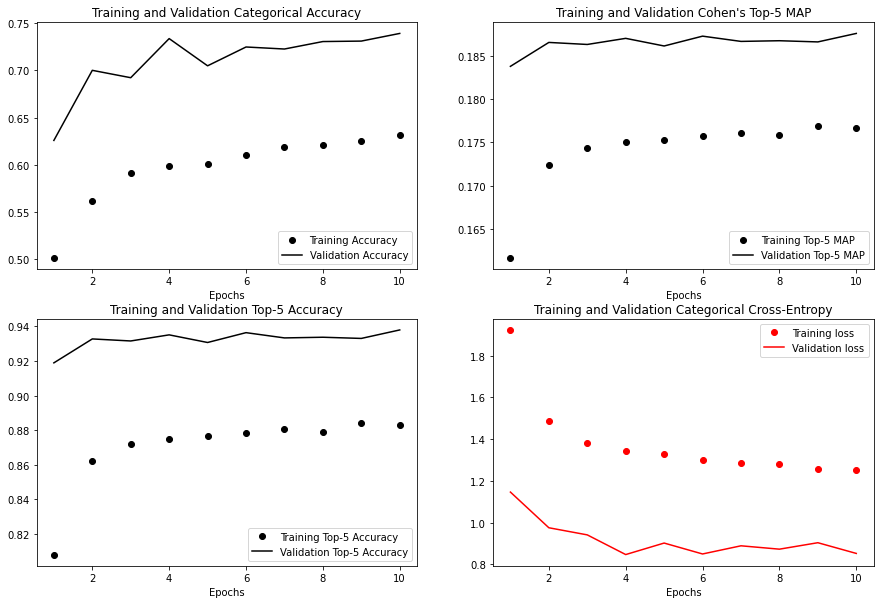

In [180]:
plot_results(history_coat0_main)

#### Fine-tuning

In [183]:
batch_size = 64
steps_per_epoch = len(df_train) * 0.8 / batch_size
validation_steps = len(df_train) * 0.2 / batch_size
epochs = 10

In [184]:
coatnet0_base.trainable = True

for layer in coatnet0_base.layers[:-7]:
    layer.trainable = False
for layer in coatnet0_base.layers[-7:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

metrics = [tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
           tf.keras.metrics.TopKCategoricalAccuracy(5, name="top_5_acc"),
           tf.keras.metrics.Precision(top_k=5, name="top_5_map")]

model_coat0_main.compile(loss='categorical_crossentropy',
                         optimizer=optimizers.Adam(learning_rate=1e-5),
                         metrics=metrics)

model_coat0_main.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
coatnet0 (Functional)        (None, 7, 7, 768)         23075178  
_________________________________________________________________
flatten (Flatten)            (None, 37632)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               9634048   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                6682      
Total params: 32,715,908
Trainable params: 14,950,682
Non-trainable params: 17,765,226
_________________________________________________________________


In [185]:
%%time

filepath = work_dir + "/coat_main_wts.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1)

history_coat0_main_ft = model_coat0_main.fit(
    coat_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=coat_val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint, earlystop, reduce_lr]
)

Epoch 1/10
637/637 [==============================] - 386s 593ms/step - loss: 1.2256 - accuracy: 0.6302 - top_5_acc: 0.8875 - top_5_map: 0.1775 - val_loss: 0.7867 - val_accuracy: 0.7664 - val_top_5_acc: 0.9430 - val_top_5_map: 0.1886

Epoch 00001: val_accuracy improved from -inf to 0.76641, saving model to ./jpeg-happywhale-384x384/coat_main_wts.hdf5
Epoch 2/10
637/637 [==============================] - 379s 594ms/step - loss: 1.1606 - accuracy: 0.6486 - top_5_acc: 0.8940 - top_5_map: 0.1788 - val_loss: 0.7842 - val_accuracy: 0.7650 - val_top_5_acc: 0.9434 - val_top_5_map: 0.1887

Epoch 00002: val_accuracy did not improve from 0.76641
Epoch 3/10
637/637 [==============================] - 377s 590ms/step - loss: 1.1267 - accuracy: 0.6543 - top_5_acc: 0.8955 - top_5_map: 0.1791 - val_loss: 0.8152 - val_accuracy: 0.7557 - val_top_5_acc: 0.9406 - val_top_5_map: 0.1881

Epoch 00003: val_accuracy did not improve from 0.76641
Epoch 4/10
637/637 [==============================] - 455s 713ms/st

In [186]:
model_coat0_main.load_weights(filepath)

model_coat0_main.save(work_dir + '/coat0_main.h5')

with open(work_dir + '/coat0_hist_main_ft.pickle', 'wb') as handle:
    pickle.dump(history_coat0_main_ft.history, handle,
                protocol=pickle.HIGHEST_PROTOCOL)

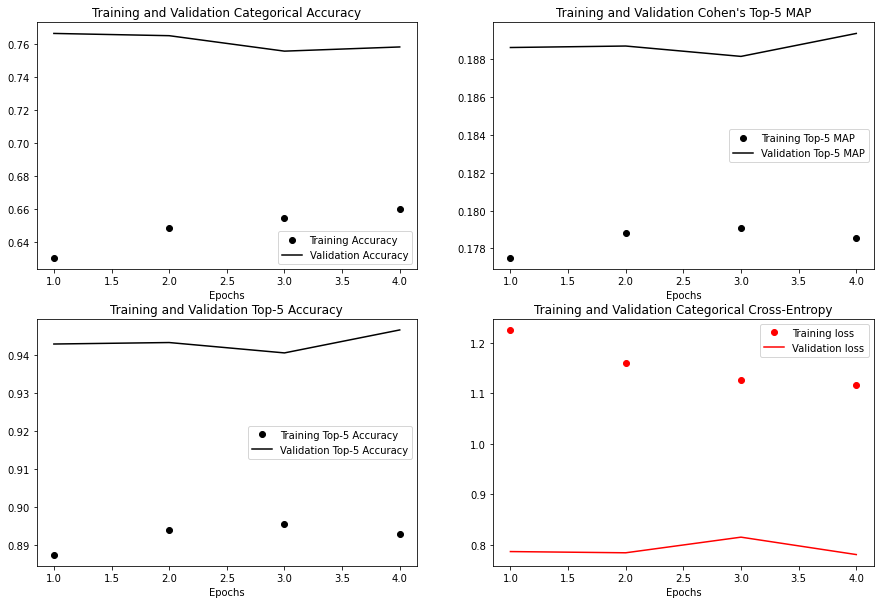

In [187]:
plot_results(history_coat0_main_ft)

### Changes to make:

1. preprocess input (https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input)
2. change to label
3. add topkcategorical accuracy as a metric
4. lower learning rate when fine-tuning
5. use larger/original dataset
6. more loss metrics
7. checkpointing



In [42]:
#     model.compile(
#         optimizer=optimizer,
#         loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#         metrics=[
#             keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
#             keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
#         ],
#     )

'1.19.5'